# Image translation (Virtual Staining)

Written by Eduardo Hirata-Miyasaki, Ziwen Liu, and Shalin Mehta, CZ Biohub San Francisco.

## Overview

In this exercise, we will:
- Train a phase to fluorescence model to predict fluorescence images of
nuclei and plasma membrane markers from quantitative phase images of cells
- Train a fluorescence to phase model


<div class="alert alert-danger">
Set your python kernel to <span style="color:black;">img2img</span>
</div>



## Part 1: Log training data to tensorboard, start training a model.
---------
Learning goals:

- Load the OME-zarr dataset and examine the channels (A549).
- Configure and understand the data loader.
- Log some patches to tensorboard.
- Train a 2D UNeXt2 model for virtual staining of nuclei and membrane from phase.
- Evaluate the model on test data.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchview
import torchvision
from iohub import open_ome_zarr
from iohub.reader import print_info
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from numpy.typing import ArrayLike
from skimage import metrics  # for metrics.

# pytorch lightning wrapper for Tensorboard.
from torch.utils.tensorboard import SummaryWriter  # for logging to tensorboard
from tqdm import tqdm

# HCSDataModule makes it easy to load data during training.
from viscy.data.hcs import HCSDataModule
from viscy.trainer import VisCyTrainer

# training augmentations
from viscy.transforms import (
    NormalizeSampled,
    RandAdjustContrastd,
    RandAffined,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandScaleIntensityd,
    RandWeightedCropd,
)

# Trainer class and UNet.
from viscy.translation.engine import MixedLoss, VSUNet

/hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed random number generators for reproducibility.
seed_everything(42, workers=True)

# Paths to data and log directory
# TODO: Change this to point to your data directory.
top_dir = Path("~/data").expanduser()

data_path = top_dir / "img2img/training/a549_hoechst_cellmask_train_val.zarr"
log_dir = top_dir / "img2img/logs/"

if not data_path.exists():
    raise FileNotFoundError(
        f"Data not found at {data_path}. Please check the top_dir and data_path variables."
    )

Seed set to 42


In [3]:
# Create log directory if needed, and launch tensorboard
log_dir.mkdir(parents=True, exist_ok=True)


The next cell starts tensorboard.

<div class="alert alert-warning">
If you launched jupyter lab from ssh terminal, add <code>--host &lt;your-server-name&gt;</code> to the tensorboard command below. <code>&lt;your-server-name&gt;</code> is the address of your compute node that ends in amazonaws.com.

</div>

<div class="alert alert-warning">
If you are using VSCode and a remote server, you will need to forward the port to view the tensorboard. <br>
Take note of the port number was assigned in the previous cell.(i.e <code> http://localhost:{port_number_assigned}</code>) <br>

Locate the your VSCode terminal and select the <code>Ports</code> tab <br>
<ul>
<li>Add a new port with the <code>port_number_assigned</code>
</ul>
Click on the link to view the tensorboard and it should open in your browser.
</div>


In [4]:
# Function to find an available port
def find_free_port():
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        return s.getsockname()[1]


# Launch TensorBoard on the browser
def launch_tensorboard(log_dir):
    import subprocess

    port = find_free_port()
    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process


# Launch tensorboard and click on the link to view the logs.
tensorboard_process = launch_tensorboard(log_dir)

TensorBoard started at http://localhost:51097. 
If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL.



### Load OME-Zarr Dataset

There should be 34 FOVs in the dataset.

Each FOV consists of 3 channels of 2048x2048 images,
saved in the [High-Content Screening (HCS) layout](https://ngff.openmicroscopy.org/latest/#hcs-layout)
specified by the Open Microscopy Environment Next Generation File Format
(OME-NGFF).

- The layout on the disk is: `row/col/field/pyramid_level/timepoint/channel/z/y/x.`



<div class="alert alert-warning">
You can inspect the tree structure by using your terminal:
<code> iohub info -v "path-to-ome-zarr" </code>

<br>
More info on the CLI:
<code>iohub info --help </code> to see the help menu.
</div>


In [5]:
# This is the python function called by `iohub info` CLI command
print_info(data_path, verbose=True)

# Open and inspect the dataset.
dataset = open_ome_zarr(data_path)

Zarr hierarchy:
/
 └── 0
     └── 0
         ├── 1
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 11
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 12
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 13
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 14
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 16
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 17
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 18
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 19
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 2
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 21
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 22
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 23
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 24
         │   └── 0 (1, 3, 9, 2048, 2048) float64
         ├── 26
         │   └── 0 (1, 3, 9, 2048, 2048)

<div class="alert alert-info">

Look at a couple different fields of view by changing the value in the cell above.
Check the cell density, the cell morphologies, and fluorescence signal.
</div>

data shape: (1, 3, 9, 2048, 2048), FOV: 9, pyramid level: 0


TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.18.0 at http://localhost:51097/ (Press CTRL+C to quit)


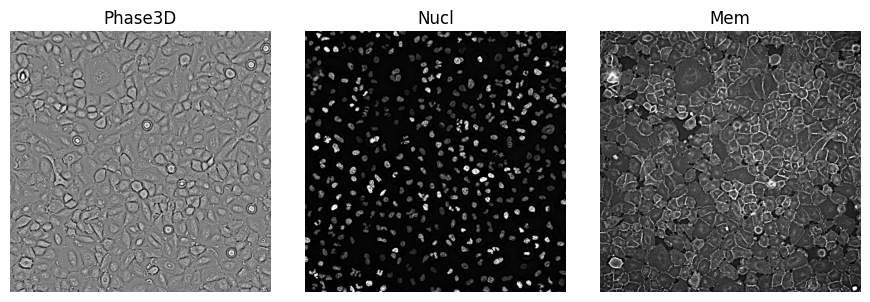

In [6]:
# Use the field and pyramid_level below to visualize data.
row = 0
col = 0
field = 9  # TODO: Change this to explore data.

# This dataset contains images at 3 resolutions.
# '0' is the highest resolution
# '1' is down-scaled 2x2,
# '2' is down-scaled 4x4.
# Such datasets are called image pyramids.
pyaramid_level = 0

# `channel_names` is the metadata that is stored with data according to the OME-NGFF spec.
n_channels = len(dataset.channel_names)

image = dataset[f"{row}/{col}/{field}/{pyaramid_level}"].numpy()
print(f"data shape: {image.shape}, FOV: {field}, pyramid level: {pyaramid_level}")

figure, axes = plt.subplots(1, n_channels, figsize=(9, 3))

for i in range(n_channels):
    for i in range(n_channels):
        channel_image = image[0, i, 0]
        # Adjust contrast to 0.5th and 99.5th percentile of pixel values.
        p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
        channel_image = np.clip(channel_image, p_low, p_high)
        axes[i].imshow(channel_image, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(dataset.channel_names[i])
plt.tight_layout()

In [7]:
def log_batch_tensorboard(batch, batchno, writer, card_name):
    """
    Logs a batch of images to TensorBoard.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.
        writer (SummaryWriter): A TensorBoard SummaryWriter object.
        card_name (str): The name of the card to be displayed in TensorBoard.

    Returns:
        None
    """
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    [N, C, H, W] = batch_phase.shape
    interleaved_images = torch.zeros((3 * N, C, H, W), dtype=batch_phase.dtype)
    interleaved_images[0::3, :] = batch_phase
    interleaved_images[1::3, :] = batch_nuclei
    interleaved_images[2::3, :] = batch_membrane

    grid = torchvision.utils.make_grid(interleaved_images, nrow=3)

    # add the grid to tensorboard
    writer.add_image(card_name, grid, batchno)

In [8]:
# Define a function to visualize a batch on jupyter, in case tensorboard is finicky
def log_batch_jupyter(batch):
    """
    Logs a batch of images on jupyter using ipywidget.

    Args:
        batch (dict): A dictionary containing the batch of images to be logged.

    Returns:
        None
    """
    batch_phase = batch["source"][:, :, 0, :, :]  # batch_size x z_size x Y x X tensor.
    batch_size = batch_phase.shape[0]
    batch_membrane = batch["target"][:, 1, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.
    batch_nuclei = batch["target"][:, 0, 0, :, :].unsqueeze(
        1
    )  # batch_size x 1 x Y x X tensor.

    p1, p99 = np.percentile(batch_membrane, (0.1, 99.9))
    batch_membrane = np.clip((batch_membrane - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_nuclei, (0.1, 99.9))
    batch_nuclei = np.clip((batch_nuclei - p1) / (p99 - p1), 0, 1)

    p1, p99 = np.percentile(batch_phase, (0.1, 99.9))
    batch_phase = np.clip((batch_phase - p1) / (p99 - p1), 0, 1)

    plt.figure()
    fig, axes = plt.subplots(
        batch_size, n_channels, figsize=(n_channels * 2, batch_size * 2)
    )
    [N, C, H, W] = batch_phase.shape
    for sample_id in range(batch_size):
        axes[sample_id, 0].imshow(batch_phase[sample_id, 0])
        axes[sample_id, 1].imshow(batch_nuclei[sample_id, 0])
        axes[sample_id, 2].imshow(batch_membrane[sample_id, 0])

        for i in range(n_channels):
            axes[sample_id, i].axis("off")
            axes[sample_id, i].set_title(dataset.channel_names[i])
    plt.tight_layout()
    plt.show()

In [9]:
# Initialize the data module.

BATCH_SIZE = 4

# 4 is a perfectly reasonable batch size
# (batch size does not have to be a power of 2)
# See: https://sebastianraschka.com/blog/2022/batch-size-2.html

data_module = HCSDataModule(
    data_path,
    z_window_size=1,
    architecture="UNeXt2_2D",
    source_channel=["Phase3D"],
    target_channel=["Nucl", "Mem"],
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    yx_patch_size=(256, 256),  # larger patch size makes it easy to see augmentations.
    augmentations=[],  # Turn off augmentation for now.
    normalizations=[],  # Turn off normalization for now.
)
data_module.setup("fit")

source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

augmentations = [
    RandWeightedCropd(
        keys=source_channel + target_channel,
        spatial_size=(1, 384, 384),
        num_samples=2,
        w_key=target_channel[0],
    ),
    RandAffined(
        keys=source_channel + target_channel,
        rotate_range=[3.14, 0.0, 0.0],
        scale_range=[0.0, 0.3, 0.3],
        prob=0.8,
        padding_mode="zeros",
        shear_range=[0.0, 0.01, 0.01],
    ),
    RandAdjustContrastd(keys=source_channel, prob=0.5, gamma=(0.8, 1.2)),
    RandScaleIntensityd(keys=source_channel, factors=0.5, prob=0.5),
    RandGaussianNoised(keys=source_channel, prob=0.5, mean=0.0, std=0.3),
    RandGaussianSmoothd(
        keys=source_channel,
        sigma_x=(0.25, 0.75),
        sigma_y=(0.25, 0.75),
        sigma_z=(0.0, 0.0),
        prob=0.5,
    ),
]

normalizations = [
    NormalizeSampled(
        keys=source_channel + target_channel,
        level="fov_statistics",
        subtrahend="mean",
        divisor="std",
    )
]

data_module.augmentations = augmentations
data_module.augmentations = normalizations

data_module.setup("fit")

# get the new data loader with augmentation turned on
augmented_train_dataloader = data_module.train_dataloader()

# Draw batches and write to tensorboard
writer = SummaryWriter(log_dir=f"{log_dir}/view_batch")
augmented_batch = next(iter(augmented_train_dataloader))
log_batch_tensorboard(augmented_batch, 0, writer, "augmentation/some")
writer.close()

Visualize directly on Jupyter

<Figure size 640x480 with 0 Axes>

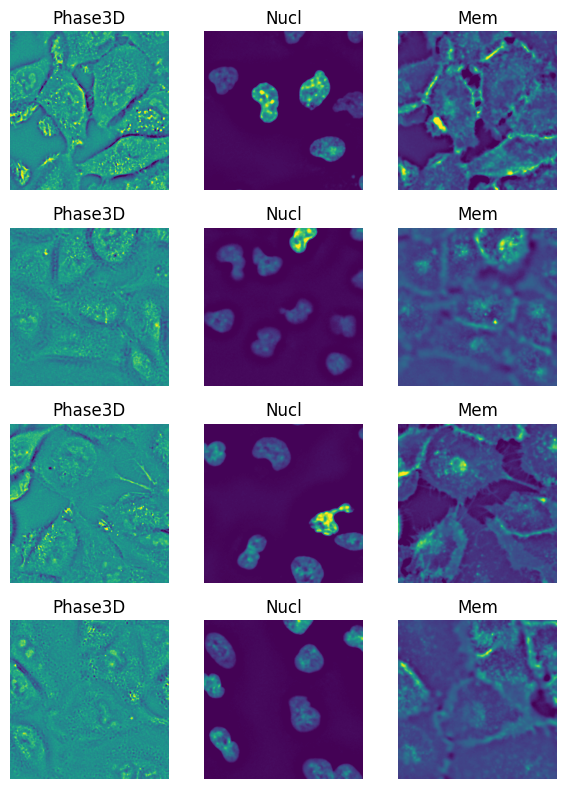

In [10]:
log_batch_jupyter(augmented_batch)

<div class="alert alert-info">
<h3>Train a 2D U-Net model to predict nuclei and membrane from phase.</h3><br>

### Construct a 2D UNeXt2 using VisCy <br>
See ``viscy.unet.networks.Unet2D.Unet2d`` ([source code](https://github.com/mehta-lab/VisCy/blob/7c5e4c1d68e70163cf514d22c475da8ea7dc3a88/viscy/unet/networks/Unet2D.py#L7)) for configuration details.
</div>

In [11]:
# Create a 2D UNet.
GPU_ID = 0

BATCH_SIZE = 12
YX_PATCH_SIZE = (256, 256)

# Dictionary that specifies key parameters of the model.

phase2fluor_config = dict(
    in_channels=1,
    out_channels=2,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,
    pretraining=False,
)

phase2fluor_model = VSUNet(
    architecture="UNeXt2_2D",  # 2D UNeXt2 architecture
    model_config=phase2fluor_config.copy(),
    loss_function=MixedLoss(l1_alpha=0.5, l2_alpha=0.0, ms_dssim_alpha=0.5),
    schedule="WarmupCosine",
    lr=6e-4,
    log_batches_per_epoch=5,  # Number of samples from each batch to log to tensorboard.
    freeze_encoder=False,
)

### Instantiate data module and trainer, test that we are setup to launch training.

In [12]:
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]
# Setup the data module.
phase2fluor_2D_data = HCSDataModule(
    data_path,
    architecture="UNeXt2_2D",
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    yx_patch_size=YX_PATCH_SIZE,
    augmentations=augmentations,
    normalizations=normalizations,
)
phase2fluor_2D_data.setup("fit")
# fast_dev_run runs a single batch of data through the model to check for errors.
trainer = VisCyTrainer(accelerator="gpu", devices=[GPU_ID], fast_dev_run=True)

# trainer class takes the model and the data module as inputs.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_2D_data)

/hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | 

Epoch 0: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, loss/train_step=0.457, loss/train_epoch=0.457]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:06<00:00,  0.17it/s, loss/train_step=0.457, loss/train_epoch=0.457]


### View model graph.
visualize graph of phase2fluor model as image.
model_graph_phase2fluor = torchview.draw_graph(
    phase2fluor_model,
    phase2fluor_2D_data.train_dataset[0]["source"][0].unsqueeze(dim=0),
    roll=True,
    depth=3,  # adjust depth to zoom in.
    device="cpu",
    # expand_nested=True,
)
Print the image of the model.
model_graph_phase2fluor.visual_graph

In [13]:
# Check if GPU is available
# You can check by typing `nvidia-smi`
GPU_ID = 0

n_samples = len(phase2fluor_2D_data.train_dataset)
steps_per_epoch = n_samples // BATCH_SIZE  # steps per epoch.
n_epochs = 10  # Set this to 50 or the number of epochs you want to train for.

trainer = VisCyTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch // 2,
    # log losses and image samples 2 times per epoch.
    logger=TensorBoardLogger(
        save_dir=log_dir,
        # lightning trainer transparently saves logs and model checkpoints in this directory.
        name="phase2fluor",
        log_graph=True,
    ),
)
# Launch training and check that loss and images are being logged on tensorboard.
trainer.fit(phase2fluor_model, datamodule=phase2fluor_2D_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode  | In sizes            | Out sizes          
------------------------------------------------------------------------------------------------------------
0 | model         | FullyConvolutionalMAE | 31.2 M | train | [1, 1, 1, 256, 256] | [1, 2, 1, 256, 256]
1 | loss_function | MixedLoss             | 0      | train | ?                   | ?                  
------------------------------------------------------------------------------------------------------------
31.2 M    Trainable params
0         Non-trainable params
31.2 M    Total params
124.644   Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode
/hpc/mydata/eduardo.hirata/repos/viscy/viscy/unet/networks/fcmae.py:290: TracerWarning: Converting a tensor to a Python b

Epoch 9: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s, v_num=3, loss/train_step=0.543, loss/train_epoch=0.517]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s, v_num=3, loss/train_step=0.543, loss/train_epoch=0.517]



Let's compute metrics directly and plot below.


In [14]:
# Setup the test data module.
test_data_path = top_dir / "img2img/test/a549_hoechst_cellmask_test.zarr"
source_channel = ["Phase3D"]
target_channel = ["Nucl", "Mem"]

test_data = HCSDataModule(
    test_data_path,
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    batch_size=1,
    num_workers=8,
    architecture="UNeXt2",
)
test_data.setup("test")

Computing metrics per sample: 100%|██████████| 7/7 [02:06<00:00, 18.13s/it]


<Axes: >

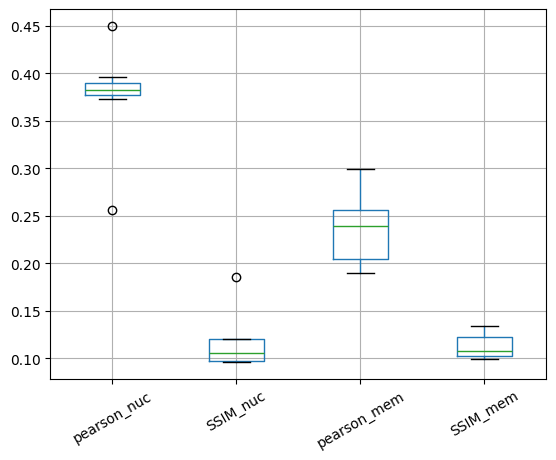

In [15]:
# Compute metrics directly and plot here.
test_metrics = pd.DataFrame(
    columns=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"]
)


def min_max_scale(input):
    return (input - np.min(input)) / (np.max(input) - np.min(input))


def normalize_fov(input: ArrayLike):
    "Normalizing the fov with zero mean and unit variance"
    mean = np.mean(input)
    std = np.std(input)
    return (input - mean) / std


for i, sample in enumerate(
    tqdm(test_data.test_dataloader(), desc="Computing metrics per sample")
):
    phase_image = sample["source"]
    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = phase2fluor_model(phase_image)

    target_image = (
        sample["target"].cpu().numpy().squeeze(0)
    )  # Squeezing batch dimension.
    predicted_image = predicted_image.cpu().numpy().squeeze(0)
    phase_image = phase_image.cpu().numpy().squeeze(0)
    target_mem = min_max_scale(target_image[1, 0, :, :])
    target_nuc = min_max_scale(target_image[0, 0, :, :])
    # slicing channel dimension, squeezing z-dimension.
    predicted_mem = min_max_scale(predicted_image[1, :, :, :].squeeze(0))
    predicted_nuc = min_max_scale(predicted_image[0, :, :, :].squeeze(0))

    # Compute SSIM and pearson correlation.
    ssim_nuc = metrics.structural_similarity(target_nuc, predicted_nuc, data_range=1)
    ssim_mem = metrics.structural_similarity(target_mem, predicted_mem, data_range=1)
    pearson_nuc = np.corrcoef(target_nuc.flatten(), predicted_nuc.flatten())[0, 1]
    pearson_mem = np.corrcoef(target_mem.flatten(), predicted_mem.flatten())[0, 1]

    test_metrics.loc[i] = {
        "pearson_nuc": pearson_nuc,
        "SSIM_nuc": ssim_nuc,
        "pearson_mem": pearson_mem,
        "SSIM_mem": ssim_mem,
    }

test_metrics.boxplot(
    column=["pearson_nuc", "SSIM_nuc", "pearson_mem", "SSIM_mem"],
    rot=30,
)

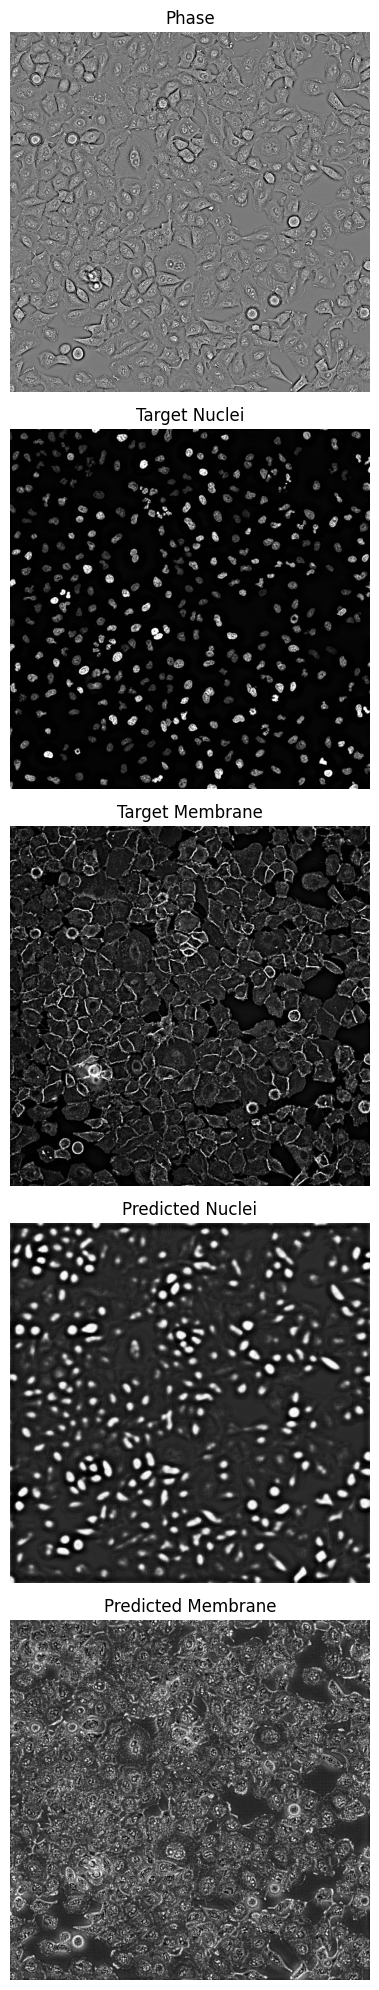

In [16]:
# Plot the predicted image
# Adjust the image to the 0.5-99.5 percentile range.
def process_image(image):
    p_low, p_high = np.percentile(image, (0.5, 99.5))
    return np.clip(image, p_low, p_high)


# Plot the predicted image vs target image.
channel_titles = [
    "Phase",
    "Target Nuclei",
    "Target Membrane",
    "Predicted Nuclei",
    "Predicted Membrane",
]
fig, axes = plt.subplots(5, 1, figsize=(20, 20))

# Get a writer to output the images into tensorboard and plot the source, predictions and target images
for i, sample in enumerate(test_data.test_dataloader()):
    # Plot the phase image
    phase_image = sample["source"]
    channel_image = phase_image[0, 0, 0]
    p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
    channel_image = np.clip(channel_image, p_low, p_high)
    axes[0].imshow(channel_image, cmap="gray")
    axes[0].set_title(channel_titles[0])

    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = (
            phase2fluor_model(phase_image.to(phase2fluor_model.device))
            .cpu()
            .numpy()
            .squeeze(0)
        )

    target_image = sample["target"].cpu().numpy().squeeze(0)
    phase_raw = process_image(phase_image[0, 0, 0])
    predicted_nuclei = process_image(predicted_image[0, 0])
    predicted_membrane = process_image(predicted_image[1, 0])
    target_nuclei = process_image(target_image[0, 0])
    target_membrane = process_image(target_image[1, 0])
    # Concatenate all images side by side
    combined_image = np.concatenate(
        (
            phase_raw,
            predicted_nuclei,
            predicted_membrane,
            target_nuclei,
            target_membrane,
        ),
        axis=1,
    )

    # Plot the phase,target nuclei, target membrane, predicted nuclei, predicted membrane
    axes[1].imshow(target_nuclei, cmap="gray")
    axes[1].set_title(channel_titles[1])
    axes[2].imshow(target_membrane, cmap="gray")
    axes[2].set_title(channel_titles[2])
    axes[3].imshow(predicted_nuclei, cmap="gray")
    axes[3].set_title(channel_titles[3])
    axes[4].imshow(predicted_membrane, cmap="gray")
    axes[4].set_title(channel_titles[4])

    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    break


<div class="alert alert-success">

<h3> Checkpoint 1 </h3>

You have now trained and evaluated a phase to fluorescence model
</div>



<div class="alert alert-info">
<h2> Part 2: Train fluorescence to phase contrast translation model.</h2><br>
Instantiate a data module, model, and trainer for fluorescence to phase contrast translation. Copy over the code from previous cells and update the parameters. Give the variables and paths a different name/suffix (fluor2phase) to avoid overwriting objects used to train phase2fluor models.

</div>

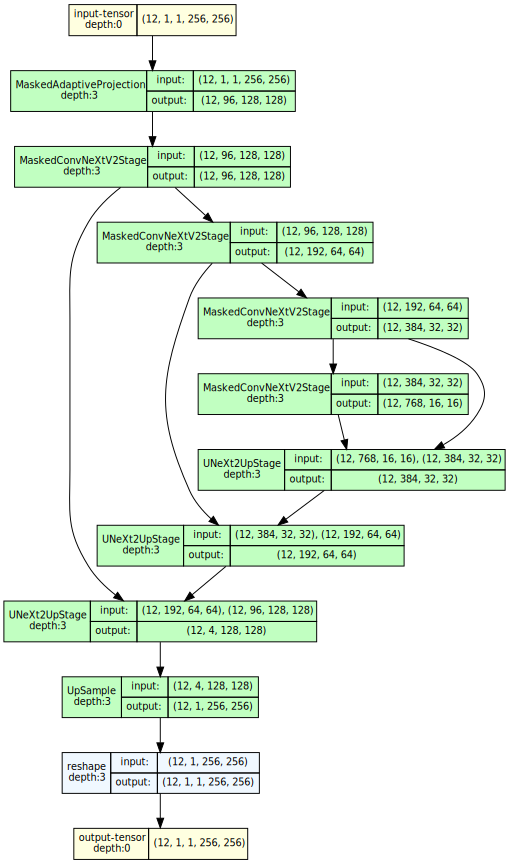

In [17]:
# The entire training loop is contained in this cell.
source_channel = ["Mem"]  # or 'Nuc' depending on choice
target_channel = ["Phase3D"]
YX_PATCH_SIZE = (256, 256)
BATCH_SIZE = 12
n_epochs = 50

# Setup the new augmentations
augmentations = [
    RandWeightedCropd(
        keys=source_channel + target_channel,
        spatial_size=(1, 384, 384),
        num_samples=2,
        w_key=target_channel[0],
    ),
    RandAffined(
        keys=source_channel + target_channel,
        rotate_range=[3.14, 0.0, 0.0],
        scale_range=[0.0, 0.3, 0.3],
        prob=0.8,
        padding_mode="zeros",
        shear_range=[0.0, 0.01, 0.01],
    ),
    RandAdjustContrastd(keys=source_channel, prob=0.5, gamma=(0.8, 1.2)),
    RandScaleIntensityd(keys=source_channel, factors=0.5, prob=0.5),
    RandGaussianNoised(keys=source_channel, prob=0.5, mean=0.0, std=0.3),
    RandGaussianSmoothd(
        keys=source_channel,
        sigma_x=(0.25, 0.75),
        sigma_y=(0.25, 0.75),
        sigma_z=(0.0, 0.0),
        prob=0.5,
    ),
]

normalizations = [
    NormalizeSampled(
        keys=source_channel + target_channel,
        level="fov_statistics",
        subtrahend="mean",
        divisor="std",
    )
]

# Setup the dataloader
fluor2phase_data = HCSDataModule(
    data_path,
    architecture="UNeXt2_2D",
    source_channel=source_channel,
    target_channel=target_channel,
    z_window_size=1,
    split_ratio=0.8,
    batch_size=BATCH_SIZE,
    num_workers=8,
    yx_patch_size=YX_PATCH_SIZE,
    augmentations=augmentations,
    normalizations=normalizations,
)
fluor2phase_data.setup("fit")

n_samples = len(fluor2phase_data.train_dataset)

steps_per_epoch = n_samples // BATCH_SIZE  # steps per epoch.

# Dictionary that specifies key parameters of the model.
fluor2phase_config = dict(
    in_channels=1,
    out_channels=1,
    encoder_blocks=[3, 3, 9, 3],
    dims=[96, 192, 384, 768],
    decoder_conv_blocks=2,
    stem_kernel_size=(1, 2, 2),
    in_stack_depth=1,
    pretraining=False,
)

fluor2phase_model = VSUNet(
    architecture="UNeXt2_2D",
    model_config=fluor2phase_config.copy(),
    loss_function=MixedLoss(l1_alpha=0.5, l2_alpha=0.0, ms_dssim_alpha=0.5),
    schedule="WarmupCosine",
    lr=6e-4,
    log_batches_per_epoch=5,  # Number of samples from each batch to log to tensorboard.
    freeze_encoder=False,
)

# Visualize the graph of fluor2phase model as image.
model_graph_fluor2phase = torchview.draw_graph(
    fluor2phase_model,
    next(iter(fluor2phase_data.train_dataloader()))["source"],
    depth=3,  # adjust depth to zoom in.
    device="cpu",
)
model_graph_fluor2phase.visual_graph

In [18]:
# Setup the trainer and dataloader for testing
trainer = VisCyTrainer(
    accelerator="gpu",
    devices=[GPU_ID],
    max_epochs=n_epochs,
    log_every_n_steps=steps_per_epoch // 2,
    logger=TensorBoardLogger(
        save_dir=log_dir,
        # lightning trainer transparently saves logs and model checkpoints in this directory.
        name="fluor2phase",
        log_graph=True,
    ),
)
trainer.fit(fluor2phase_model, datamodule=fluor2phase_data)

test_data_path = Path(
    "~/data/img2img/test/a549_hoechst_cellmask_test.zarr"
).expanduser()

test_data = HCSDataModule(
    test_data_path,
    source_channel="Mem",  # or Nuc, depending on your choice of source
    target_channel="Phase3D",
    z_window_size=1,
    batch_size=1,
    num_workers=8,
    architecture="UNeXt2",
)
test_data.setup("test")

/hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /hpc/mydata/eduardo.hirata/.conda/envs/viscy_030/lib ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode  | In sizes            | Out sizes          
------------------------------------------------------------------------------------------------------------
0 | model         | FullyConvolutionalMAE | 31.2 M | train | [1, 1, 1, 256, 256] | [1, 1, 1, 256, 256]
1 | loss_function | MixedLoss             | 0      | train | ?                   | ?                  
---------------------------------------------------------

Epoch 49: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s, v_num=2, loss/train_step=0.576, loss/train_epoch=0.549]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s, v_num=2, loss/train_step=0.576, loss/train_epoch=0.549]


<Axes: >

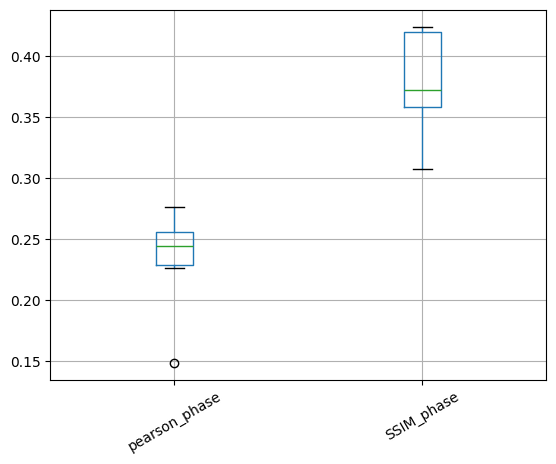

In [19]:
# Instensity based metrics on the test data.

test_metrics = pd.DataFrame(columns=["pearson_phase", "SSIM_phase"])
for i, sample in enumerate(test_data.test_dataloader()):
    source_image = sample["source"]
    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = fluor2phase_model(source_image.to(fluor2phase_model.device))

    target_image = (
        sample["target"].cpu().numpy().squeeze(0)
    )  # Squeezing batch dimension.
    predicted_image = predicted_image.cpu().numpy().squeeze(0)
    source_image = source_image.cpu().numpy().squeeze(0)
    target_phase = min_max_scale(target_image[0, 0, :, :])
    # slicing channel dimension, squeezing z-dimension.
    predicted_phase = min_max_scale(predicted_image[0, :, :, :].squeeze(0))

    # Compute SSIM and pearson correlation.
    ssim_phase = metrics.structural_similarity(
        target_phase, predicted_phase, data_range=1
    )
    pearson_phase = np.corrcoef(target_phase.flatten(), predicted_phase.flatten())[0, 1]

    test_metrics.loc[i] = {
        "pearson_phase": pearson_phase,
        "SSIM_phase": ssim_phase,
    }

test_metrics.boxplot(
    column=["pearson_phase", "SSIM_phase"],
    rot=30,
)

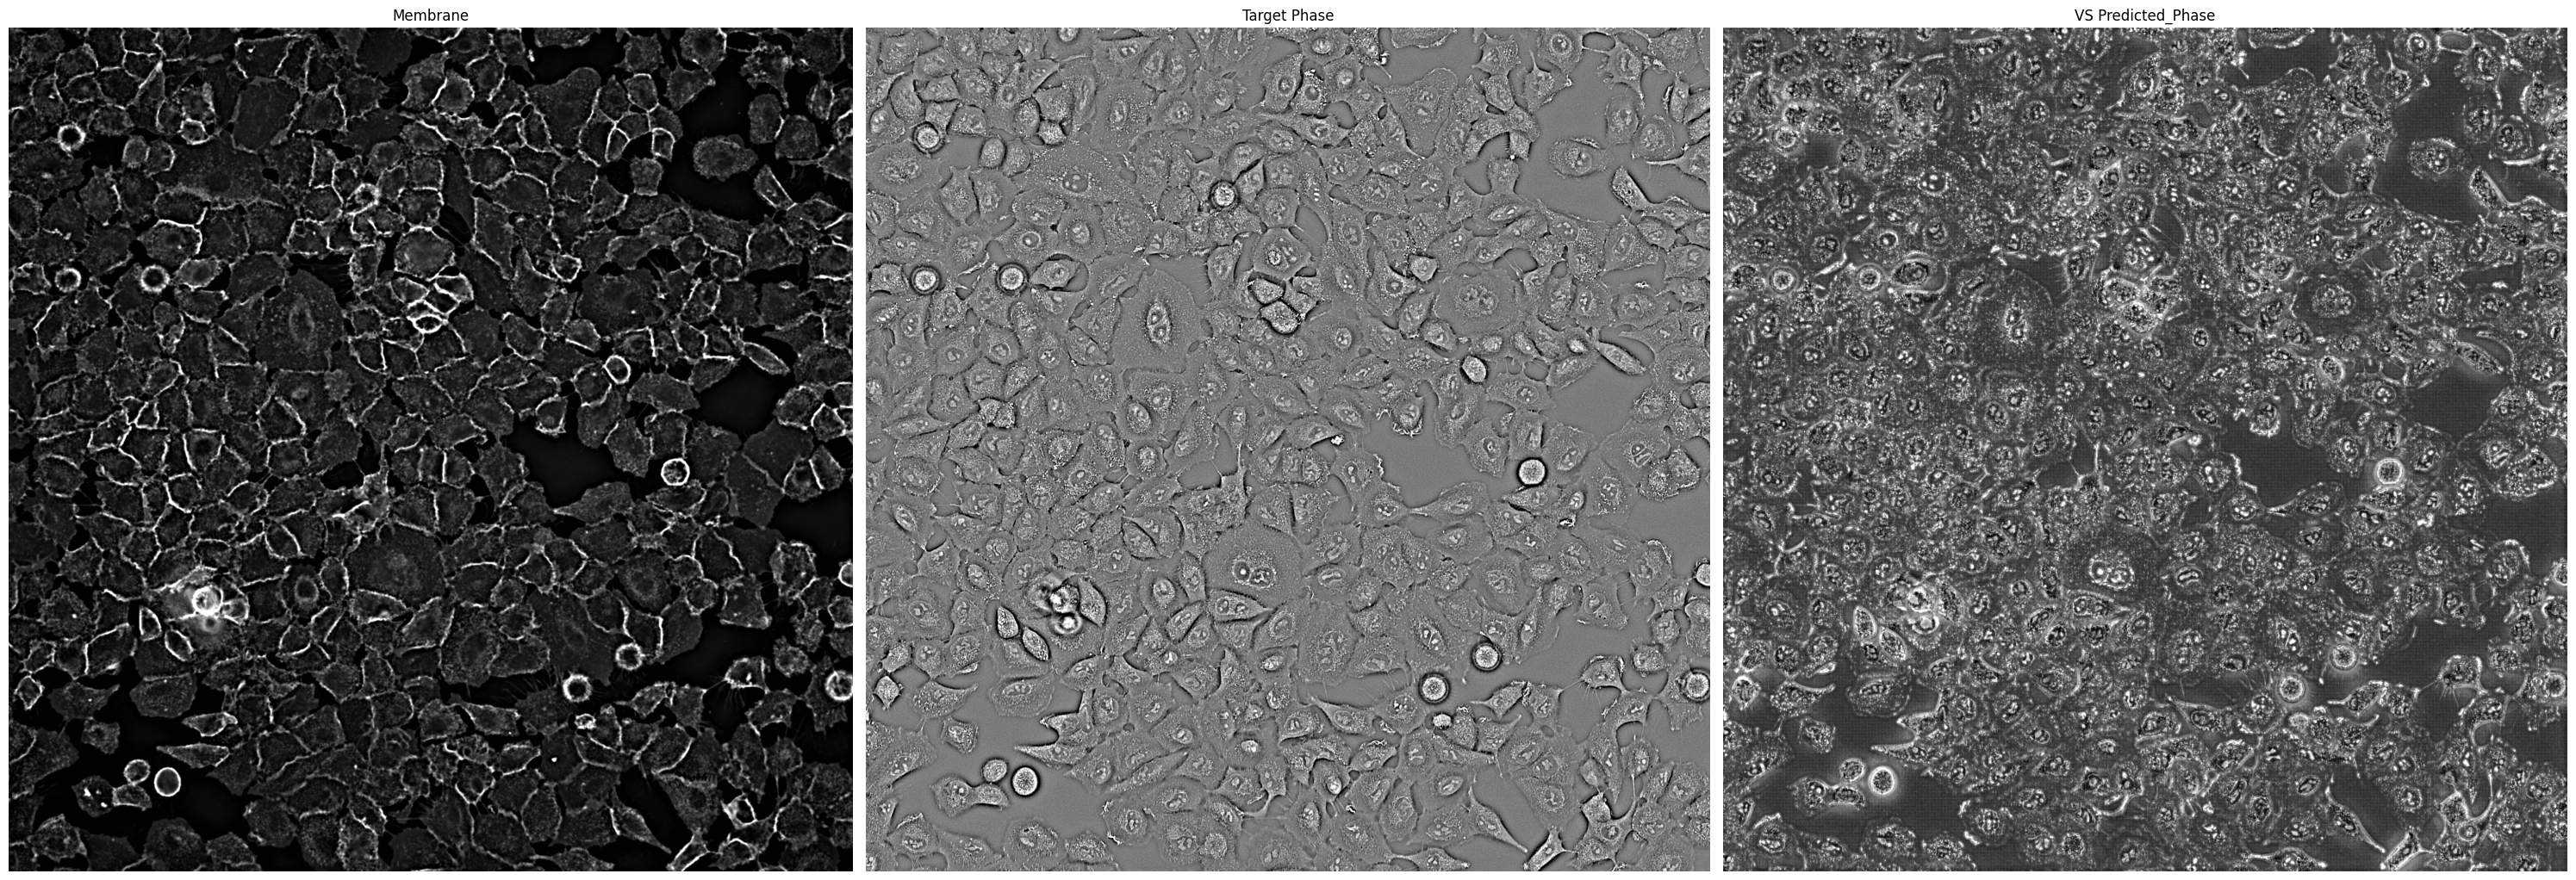

In [20]:
# Plot the predicted image
channel_titles = [
    "Membrane",
    "Target Phase",
    "Predicted_Phase",
]
fig, axes = plt.subplots(1, 3, figsize=(30, 20))

for i, sample in enumerate(test_data.test_dataloader()):
    # Plot the phase image
    mem_image = sample["source"]
    channel_image = mem_image[0, 0, 0]
    p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
    channel_image = np.clip(channel_image, p_low, p_high)
    axes[0].imshow(channel_image, cmap="gray")
    axes[0].axis("off")
    axes[0].set_title(channel_titles[0])

    with torch.inference_mode():  # turn off gradient computation.
        predicted_image = (
            phase2fluor_model(phase_image.to(phase2fluor_model.device))
            .cpu()
            .numpy()
            .squeeze(0)
        )

    target_image = sample["target"].cpu().numpy().squeeze(0)
    # Plot the predicted images
    channel_image = target_image[0, 0]
    p_low, p_high = np.percentile(channel_image, (0.5, 99.5))
    channel_image = np.clip(channel_image, p_low, p_high)
    axes[1].imshow(channel_image, cmap="gray")
    axes[1].axis("off")
    axes[1].set_title(channel_titles[1])

    channel_image = predicted_image[1, 0]
    p_low, p_high = np.percentile(channel_image, (0.1, 99.5))
    channel_image = np.clip(channel_image, p_low, p_high)
    axes[2].imshow(channel_image, cmap="gray")
    axes[2].axis("off")
    axes[2].set_title(f"VS {channel_titles[2]}")

    plt.tight_layout()
    plt.show()
    break

<div class="alert alert-success">
<h2> 
🎉 The end of the notebook 🎉
</h2>

Congratulations! You have trained several image translation models now!
</div>